YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


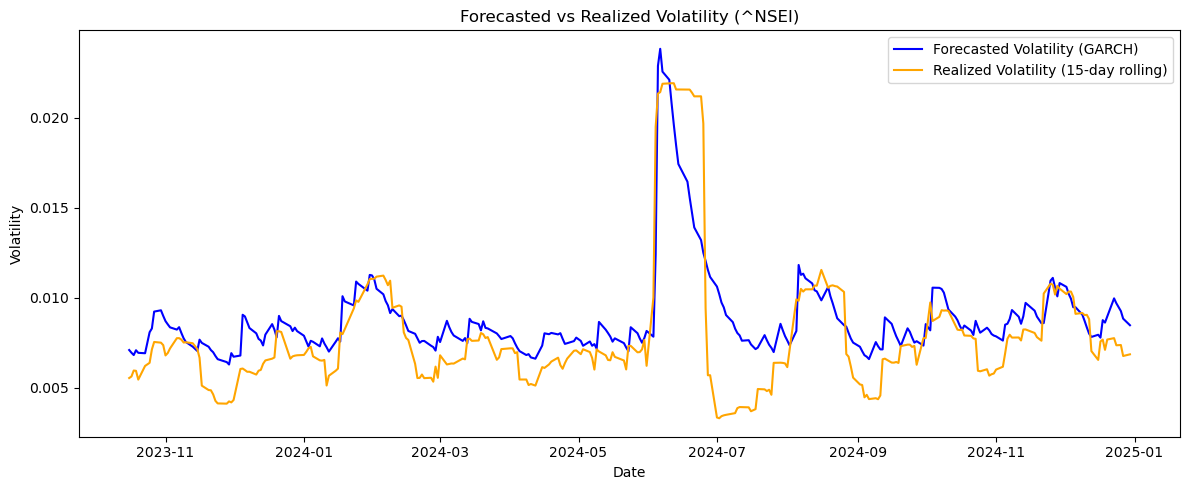

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4799.09
Distribution:                  Normal   AIC:                          -9590.18
Method:            Maximum Likelihood   BIC:                          -9569.00
                                        No. Observations:                 1475
Date:                Mon, Jul 21 2025   Df Residuals:                     1474
Time:                        21:10:53   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.8099e-04  9.988e-05      7.820  5.303e-15 [5.

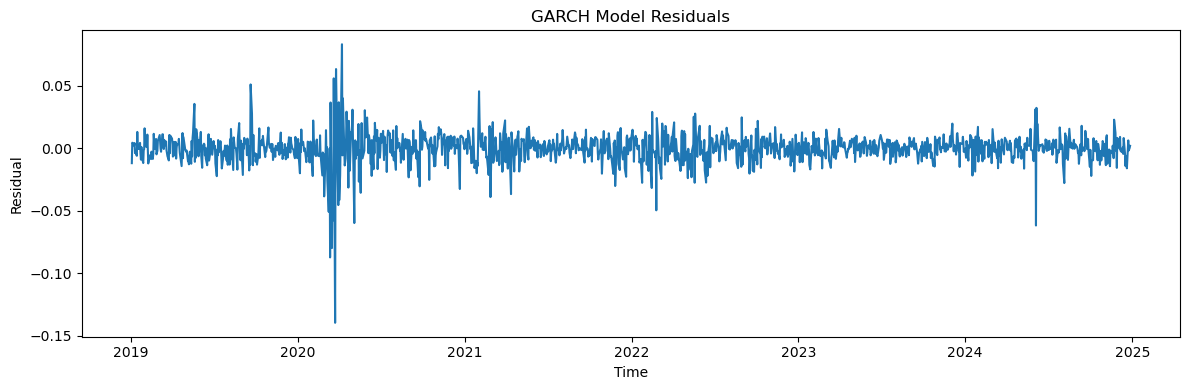

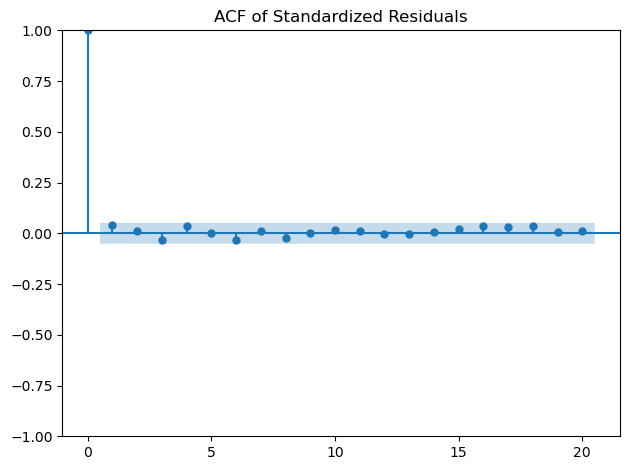

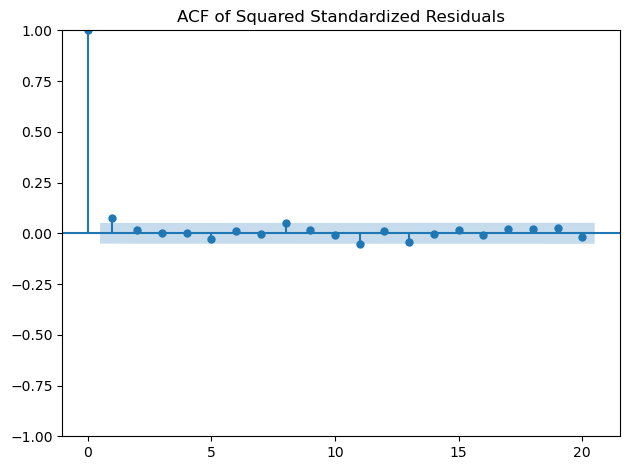

{'MAE': 0.00158198558017829, 'MSE': 4.492463233161554e-06, 'RMSE': 0.0021195431661472607, 'MAPE (%)': 25.31235839670917}


In [1]:
#This code will give 4 plots and all the error metrics explained in the report
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")


def forecast_metrics(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        
        'MAPE (%)': mape
    }


ticker = "^NSEI" #change the ticker for the stock you want
data = yf.download(ticker, start="2019-01-01", end="2024-12-31") #adjust the start and end dates for the data

data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
returns = data['LogReturn'].dropna()

split_index = int(0.8 * len(returns))
train_returns = returns[:split_index]
test_returns = returns[split_index:]

forecasted_vol = []
realized_vol = []
window_size = 15  # for rolling actual volatility

for i in range(len(test_returns)):
    rolling_window = returns[:split_index + i]
    
    model = arch_model(rolling_window, vol='GARCH', p=1, q=1)
    model_fit = model.fit(disp="off")
    
    forecast = model_fit.forecast(horizon=1)
    forecasted_vol.append(np.sqrt(forecast.variance.iloc[-1, 0]))
    
    if split_index + i >= window_size:
        realized = returns[split_index + i - window_size + 1 : split_index + i + 1].std()
        realized_vol.append(realized)
    else:
        realized_vol.append(np.nan) 

dates = test_returns.index

plt.figure(figsize=(12, 5))
plt.plot(dates, forecasted_vol, label='Forecasted Volatility (GARCH)', color='blue')
plt.plot(dates, realized_vol, label=f'Realized Volatility ({window_size}-day rolling)', color='orange')
plt.title(f"Forecasted vs Realized Volatility ({ticker})")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

print(model_fit)

residuals = model_fit.resid
std_residuals = model_fit.std_resid

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("GARCH Model Residuals")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

plot_acf(std_residuals.dropna(), lags=20)
plt.title("ACF of Standardized Residuals")
plt.tight_layout()
plt.show()

plot_acf(std_residuals.dropna()**2, lags=20)
plt.title("ACF of Squared Standardized Residuals")
plt.tight_layout()
plt.show()

print(forecast_metrics(realized_vol, forecasted_vol))
